# Feature Importance Rank for Perovskite Capping Layer Degradation (Non-Normalized, Excluding PTEAI)
20200409 - Titan Hartono (MIT), with the help from Felipe Oviedo (MIT), Armi Tiihonen (MIT), Siyu Isaac P. Tian (SMART), Zekun Danny Ren (SMART). 

## Introduction

We are trying to find the model that best relates the experimental data that we have acquired (in our case, it's the perovskite capping layer degradation data) which is $y$, with the molecular properties of the capping layer materials which is $X$. 

Since we are trying to predict the degradation parameters, which are continuous value, we will be doing regression in supervised learning.

## Loading Dataset & Libraries

First, we start by importing the libraries, and the datasets consisting of the molecular features, and the degradation parameters from the pre-processed image data. 

**WHAT YOU NEED TO CHANGE**:
1. The directory of the .csv files you are going to load. If you change the .csv filenames, please change that as well.

In [1]:
# Import libraries to be used, make sure they are all installed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
from IPython.display import display_html
import seaborn as sns 

The features ($X$) that consist of processing conditions and molecular features are the following. The molecular features are taken from PubChem 2019 database, the complete explanation can be seen on Glossary of PubChem: https://pubchemdocs.ncbi.nlm.nih.gov/glossary. 

Several molecular features are not included, such as #H-bond acceptor, # of other atoms (Cl, O), atom/ bond stereocenter count, due to the fact that within the *A*-site cations/ molecules we are exploring, their values are the same.

| Feature | Type | Explanation |
| --- | --- | ---------- |
| Concentration | Processing condition | The concentration of the capping layer precursor solution in milimol/L (mM) |
| Annealing temp. | Processing condition | The temperature for annealing of the capping layer, in Celsius |
| Molecular weight | Molecular feature | The molecular weight of capping layer compound, in g/mol |
| #C atom | Molecular feature | The total number of carbon atoms in the capping layer compound |
| #H atom | Molecular feature | The total number of hydrogen atoms in the capping layer compound |
| #Br atom | Molecular feature | The total number of bromine atoms in the capping layer compound |
| #I atom | Molecular feature | The total number of iodine atoms in the capping layer compound |
| #N atom | Molecular feature | The total number of nitrogen atoms in the capping layer compound |
| #H-bond donor | Molecular feature | The total number of hydrogen bond donors in the capping layer compound, computed using Cactvs 3.4.6.11 |
| #Rotatable bond | Molecular feature | The total number of rotatable bonds in the capping layer compound, computed using Cactvs 3.4.6.11 |
| Top. polar surface area | Molecular feature | An estimate of the polar area in Angstrom ($\mathring A$), computed using Cactvs 3.4.6.11 |
| #Heavy atom | Molecular feature | The total number of non-hydrogen atoms in the capping layer compound |
| Complexity | Molecular feature | The estimate of how complicated the structure is, based on the elements and symmetry, but not stereochemistry or isotope labelling, computed using Cactvs 3.4.6.11 |
| Partition coeff. | Molecular feature | The prediction of octanol-water partition coefficient/ distribution coefficient (XLogP), and an estimate of hydrophilicity/ hydrophobicity of a molecule, computed using XLogP3 3.0 |

In [2]:
# Import the perovskite degradation data
from collections import OrderedDict
cmaps = OrderedDict()

## IMPORTING DATA

# Change directory to where your .csv file is
# os.chdir('C:/Users/Titan/Dropbox (MIT)/PV/Campaign_2/cappingML/')
# os.chdir('C:/Users/Noor Titan Hartono/20200326_cappingML/')

# Load the .csv file 

# The molecular features & processing conditions are loaded as X
degData_X = pd.read_csv('dataset/input_noPTEAI.csv') 

# Check if the data is loaded and separated correctly
pd.set_option('max_rows', 10)
degData_X

,Concentration (mM),Annealing T,Molecular Weight,# C atom,# H atom,# Br atom,# I atom,# N atom,# H-bond Donor,# Rotatable Bond,Top. Polar Surface Area,# Heavy Atom,Complexity,Partition Coeff.
0,5,100,188.068,7,10,1,0,1,1,1,27.6,9,55.4,1.1
1,10,100,188.068,7,10,1,0,1,1,1,27.6,9,55.4,1.1
2,15,100,188.068,7,10,1,0,1,1,1,27.6,9,55.4,1.1
3,5,50,235.070,7,10,0,1,1,1,1,27.6,9,55.4,1.1
4,10,50,235.070,7,10,0,1,1,1,1,27.6,9,55.4,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,10,125,312.267,12,28,0,1,1,0,8,0.0,14,80.2,3.9
194,15,125,312.267,12,28,0,1,1,0,8,0.0,14,80.2,3.9
195,10,75,312.267,12,28,0,1,1,0,8,0.0,14,80.2,3.9
196,10,75,312.267,12,28,0,1,1,0,8,0.0,14,80.2,3.9


In [3]:
# Read the dataframe of degradation data
dataValues_X = pd.DataFrame(degData_X)
X = dataValues_X

Next, we are going to load the experimental degradation parameters ($y$), which is already cleaned. From each degradation image, we can extract the RGB (red, green, blue) color values, which has been calibrated. 

Because we observe that the blue color value doesn't change much over time, and because the yellow color comes from the red and green, we are extracting the parameters from the red and green (RG) colors only. 
<img src="images/RG_cappingMaterials_1.png" alt="Drawing" style="width: 400px;"/>

Since the R and G overlaps, we can choose either color for the degradation parameters to be extracted from.

The image below shows the degradation profile of red color for one of the capped films.
<img src="images/14-10mM_TBAI_100C_red_edited_2.png" alt="Drawing" style="width: 300px;"/>

We can extract: the slope of the degradation onset, the time-intercept of the degradation onset, the time when it reaches maximum red value (i.e. undergoes maximum change), and so on. 

The parameters we are extracting, and hence, are available on the dataset are the following. R refers to the red degradation curve, and G refers to the green degradation curve.

| Degradation parameters | Explanation |
| --- | --- |
| param1_r | Slope of R onset |
| param2_r | y-intercept of R onset |
| xinterp_r | x-intercept/ time-intercept of R onset |
| max_x_r | x/ time at maximum change in R |
| param1_g | slope of G onset |
| param2_g | y-intercept of G onset |
| xinterp_g | x-intercept/ time-intercept of G onset |
| max_x_g | x/ time at maximum change in G |

In [4]:
# Change directory to where your .csv file is
# os.chdir('C:/Users/Titan/Dropbox (MIT)/PV/Campaign_2/cappingML/')
# os.chdir('C:/Users/Noor Titan Hartono/20200326_cappingML/')

# Load the .csv file 

# The degradation parameters (onset, slope) is loaded
degData_y = pd.read_csv('dataset/output_noPTEAI.csv')

# Check if the data is loaded and separated correctly
pd.set_option('max_rows', 16)
degData_y

,compound,concentration_mM,annealing_T,molecular_weight,C,H,Br,I,N,Hbond_donor,...,xlogP,param1_r,param2_r,xinterp_r,max_x_r,param1_g,param2_g,xinterp_g,max_x_g,date
0,BzABr,5,100,188.068,7,10,1,0,1,1,...,1.1,1.488000,-12.070400,8.111800,175.050000,1.546800,-6.820500,4.409500,170.050000,20190530
1,BzABr,10,100,188.068,7,10,1,0,1,1,...,1.1,1.365000,-111.600000,81.758200,200.066700,1.477500,-119.027500,80.560100,210.066700,20190530
2,BzABr,15,100,188.068,7,10,1,0,1,1,...,1.1,1.444000,-189.534400,131.256500,225.066700,1.355500,-169.573000,125.100000,235.083300,20190530
3,BzAI,5,50,235.070,7,10,0,1,1,1,...,1.1,1.774500,-177.180000,99.843000,168.130000,1.557300,-150.880000,96.886000,174.130000,20190805
4,BzAI,10,50,235.070,7,10,0,1,1,1,...,1.1,1.140800,-180.970000,158.640000,255.180000,1.068300,-167.870000,157.130000,252.180000,20190805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,MAPI,0,0,158.970,1,6,0,1,1,1,...,-0.7,0.909440,-194.220000,213.560000,363.250000,0.912480,-188.110000,206.160000,357.250000,20190921
229,MAPI,0,0,158.970,1,6,0,1,1,1,...,-0.7,0.889670,-210.430000,236.530000,375.270000,0.762910,-172.930000,226.680000,381.270000,20190921
230,MAPI,0,0,158.970,1,6,0,1,1,1,...,-0.7,1.354270,-153.279197,113.182149,240.200000,1.165230,-127.011108,109.000882,237.200000,20191120
231,MAPI,0,0,158.970,1,6,0,1,1,1,...,-0.7,1.686898,-123.914234,73.456870,198.166667,2.050073,-158.593326,77.359844,159.133333,20191119


In [5]:
dataValues_y = pd.DataFrame(degData_y)

# Actual output measurements (based on the param. extraction
# from the degradation rgb plots -not considering the b)

n = 198 # We are excluding bare MAPI data, and only including the data of capped films.

par1_r = dataValues_y.values[:n,15] # slope r
par2_r = dataValues_y.values[:n,16] # y-intercept r
xint_r = dataValues_y.values[:n,17] # x-intercept r
max_x_r = dataValues_y.values[:n,18] # x @ max. r values
par1_g = dataValues_y.values[:n,19] # slope g
par2_g = dataValues_y.values[:n,20] # y-intercept g
xint_g = dataValues_y.values[:n,21] # x-intercept g
max_x_g = dataValues_y.values[:n,22] # x @ max. g values

# print(xint_r.shape)
# print(xint_r)
# print(dataValues_y.values[:n,0])

We can also check how different molecular features/ processing conditions are related to each other. From this, we know, for example, the number of rotatable bond highly depends on the number of hydrogens. 

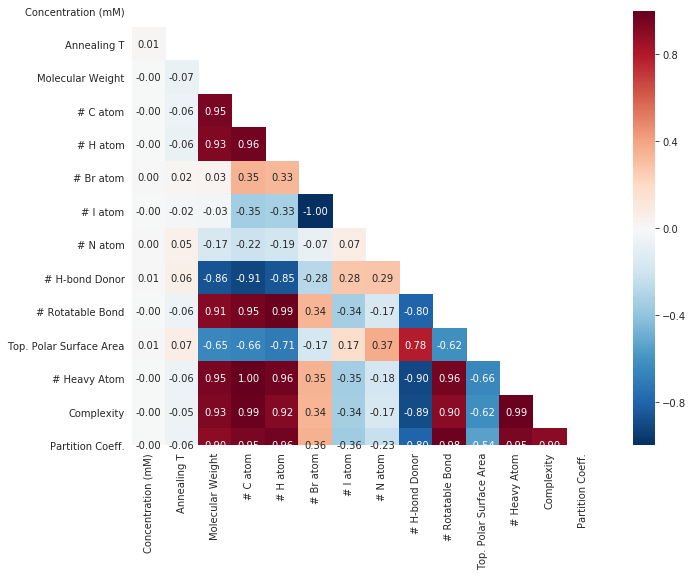

In [6]:
#Using Pearson Correlation
cor = X.corr()
mask = np.zeros_like(cor)
plt.rcParams['font.family']="Arial"
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12,8))
    ax = sns.heatmap(cor, annot=True,annot_kws={"size": 10},fmt=".2f",
                     cmap=plt.cm.RdBu_r,linewidths=0,vmin=-1,vmax=1,mask=mask, square=True)
# plt.rcParams['font.family']="Arial"

## Checking the Dataset

Now, let's check the distribution of the xinterp_r (time-intercept of R onset), governing the time point of when the degradation starts to happen, and the param1_r (slope of R onset), governing the degradation speed, based on the the capping layer compounds.

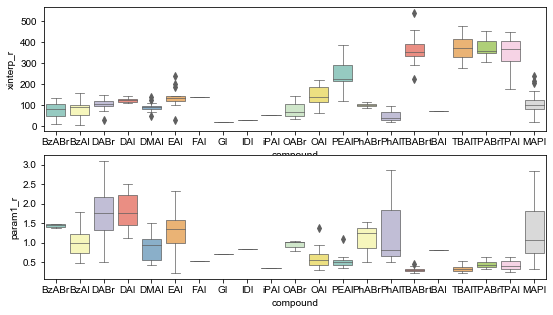

In [7]:
numerical = [
    'concentration_mM','annealing_T','molecular_weight','C','H','Br','I','N',
    'Hbond_donor','rotatable_bond','topPolar_area','heavy_atom',
    'complexity','xlogP'
]

categorical = ['compound']

# Plotting the data based on the compounds
fig, axes = plt.subplots(2,1, figsize=(9,5), sharex=False)
plt.style.use('default')
fontsize = 7.5

sns.boxplot(x='compound', y='xinterp_r', data=degData_y, 
            palette = 'Set3',ax=axes[0],linewidth=0.7)

sns.boxplot(x='compound', y='param1_r', data=degData_y, 
            palette = 'Set3',ax=axes[1],linewidth=0.7)

plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams['font.family']="Arial"

We need to confirm that our decision to choose only consider red (but can also be green) is fine. We calculate the Pearson correlation value of the x-intercept (time-intercept) and the slope of the R and G across all the data. 

The Pearson correlation value for the time-intercept = 0.995, and for the slope = 0.960. This means, we can choose either color to represent our degradation parameter in the dataset for training the machine learning algorithm.

The Pearson correlation value for time-intercept:  (0.9942270189456202, 6.135329706536537e-226)
The Pearson correlation value for slope:  (0.9577317655975851, 5.500152370810529e-127)


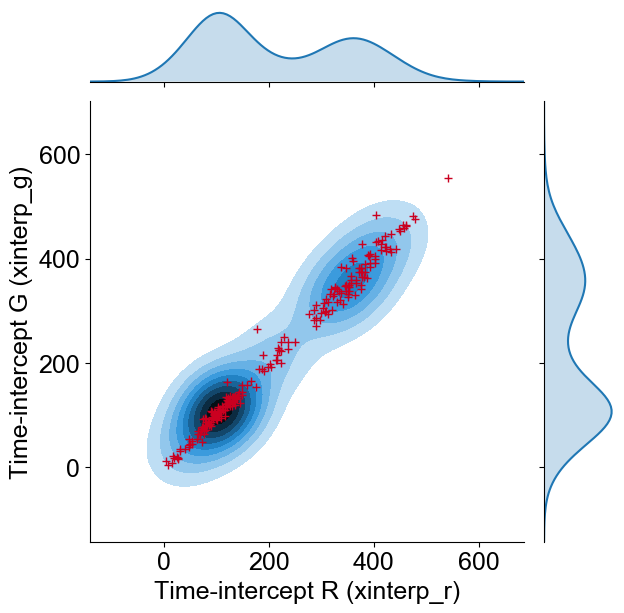

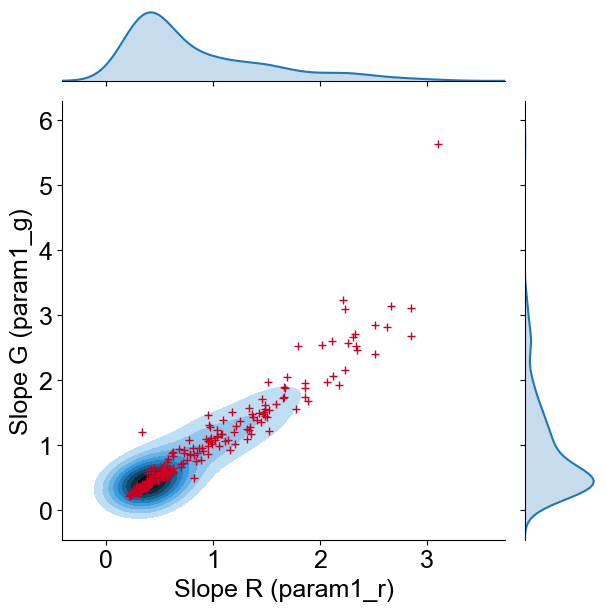

In [8]:
from scipy.stats import pearsonr

print('The Pearson correlation value for time-intercept: ',pearsonr(degData_y['xinterp_r'],degData_y['xinterp_g']))
print('The Pearson correlation value for slope: ',pearsonr(degData_y['param1_r'],degData_y['param1_g']))

g1 = sns.jointplot(x="xinterp_r", y="xinterp_g", data=degData_y, kind="kde")
plt.style.use('default')
plt.tight_layout()

plt.rcParams['font.family']="Arial"
g1.plot_joint(plt.scatter, c="#ca0020", s=40, linewidth=1, marker="+")
g1.ax_joint.collections[0].set_alpha(0)
g1.set_axis_labels("Time-intercept R (xinterp_r)", "Time-intercept G (xinterp_g)", fontsize=18)
plt.tick_params(axis="both", labelsize=18)

g2 = sns.jointplot(x="param1_r", y="param1_g", data=degData_y, kind="kde")
plt.style.use('default')
plt.tight_layout()
g2.plot_joint(plt.scatter, c="#ca0020", s=40, linewidth=1, marker="+")
g2.ax_joint.collections[0].set_alpha(0)
g2.set_axis_labels("Slope R (param1_r)", "Slope G (param1_g)", fontsize=18)
plt.tick_params(axis="both", labelsize=18)

We can also look at the degradation parameters, and see if there is any correlation between the degradation onset point (time-intercept) and the speed of the degradation onset (slope of the degradation onset). 

The Pearson correlation value between the time-intercept and the slope of R = -0.611, indicating that there's some sort of inverse relationship between the speed and the time onset of degradation. If the degradation happens sooner, then its speed is likely to be faster.

The Pearson correlation value for time-intercept & slope of R:  (-0.5879509931677143, 4.678884859799867e-23)


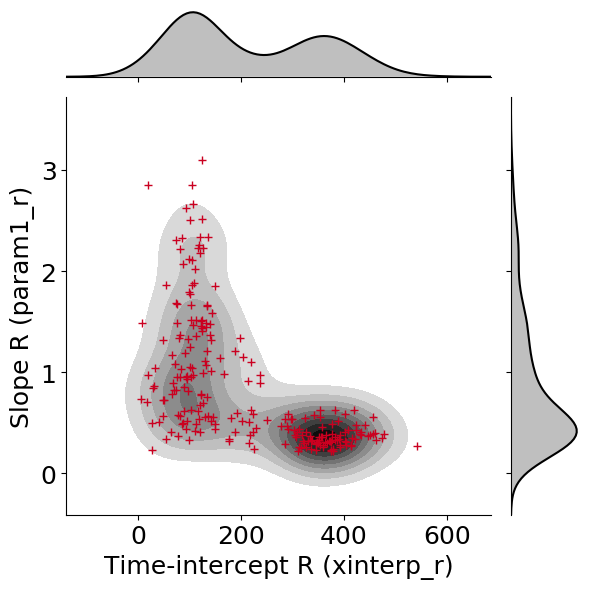

In [9]:
from scipy.stats import pearsonr
print('The Pearson correlation value for time-intercept & slope of R: ',pearsonr(degData_y['xinterp_r'],degData_y['param1_r']))

# fig, axes = plt.subplots(1,2, figsize=(5,10), sharex=False)
g1 = sns.jointplot(x="xinterp_r", y="param1_r", data=degData_y, kind="kde",color='k')
plt.style.use('default')

g1.plot_joint(plt.scatter, c="#ca0020", s=40, linewidth=1, marker="+")
g1.ax_joint.collections[0].set_alpha(0)
g1.set_axis_labels("Time-intercept R (xinterp_r)", "Slope R (param1_r)", fontsize=18)
plt.tick_params(axis="both", labelsize=18)
plt.rcParams['font.family']="Arial"
plt.tight_layout()


## Data Preprocessing

We need to split the dataset into training and test sets, so that our machine learning regressors are trained on known training data and evaluated on unknown test data. We need to choose what the degradation parameter is. Because we care about the onset (i.e. as soon as the color changes, the films are degrading), we will use $y = $ xint_r. Check that the train and test sets' shapes are consistent. 

We split the dataset randomly, where 20% of the dataset becomes a test set, and 80% of the dataset becomes a train set. It is possible to change this test size.

In [10]:
# Choose what y will be for training your models. In this case, we're using the onset intercept of red curve (R)
y = xint_r
# y = par1_r

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Test set is 20% of the total data, and the random state is set to ensure identical results for each run

print("X_train's shape is", X_train.shape,"; y_train's shape is", y_train.shape)
print("X_test's shape is", X_test.shape,"; y_test's shape is", y_test.shape)

X_train's shape is (158, 14) ; y_train's shape is (158,)
X_test's shape is (40, 14) ; y_test's shape is (40,)


### Standardization (Recommended)

Get rid of the inflated/underestimated influence of a particular feature due to its numerical magnitude. 

**Example**: from the first few rows of X, **the concentration numerically vary from 5 to 15**, while **the molecular weight from 188 to 266**. 

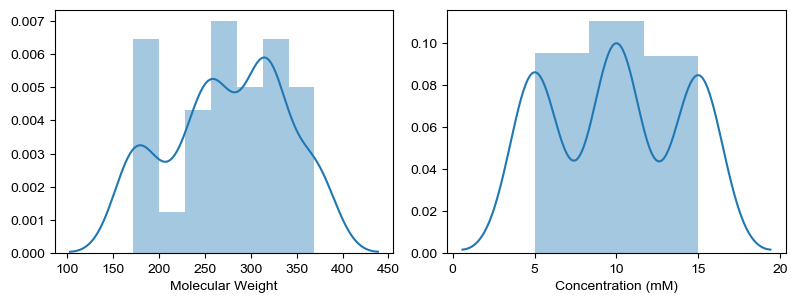

In [11]:
# Plotting the distribution of molecular weight vs. concentration
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=False)
plt.style.use('default')
plt.tight_layout()
sns.distplot(X['Molecular Weight'],ax=axes[0])
sns.distplot(X['Concentration (mM)'],ax=axes[1])

This triggers many questions. Does the molecular weight have:
> Larger influence on the output varible due to: 
*   its larger numerical magnitude?
*   its larger absolute variance?

> Or smaller influence due to:
*   its smaller regression coefficient that trys to compensate its larger numerical magnitude?
*   its smaller relative variance with respect to its numerical magnitude?

Thus, it's recommended to standardize the predictors/features to having zero mean and unit variance. Package ```sklearn``` (https://scikit-learn.org/stable/) is used to implement various preprocessing techniques including standardization.

**COMMENT/ UNCOMMENT IF YOU WANT TO SCALE/ NORMALIZE/ STANDARDIZE THE X.**

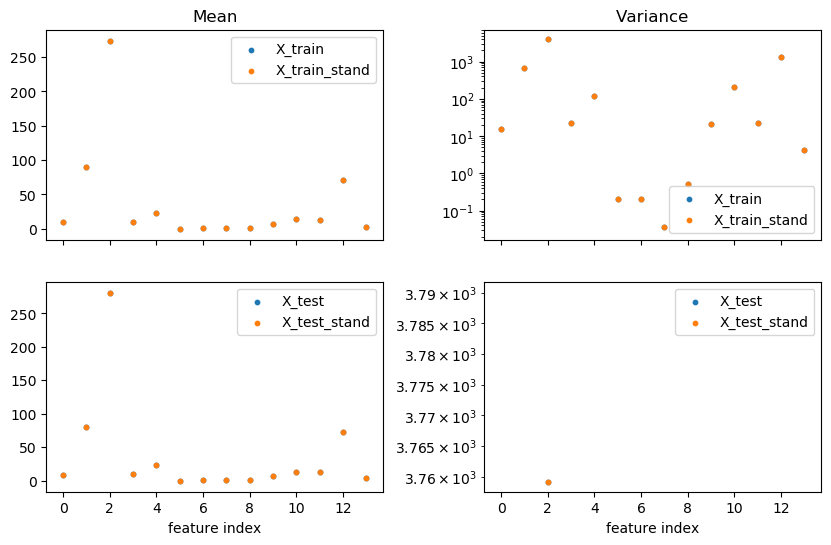

In [12]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

###############################################################################################
# UNCOMMENT THE PART BELOW IF YOU WANT TO STANDARDIZE THE X, AND COMMENT THE OTHER PART
###############################################################################################
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train_stand = scaler.transform(X_train)
# X_test_stand = scaler.transform(X_test) 
# Take care to use the scaler fitted on the training set to transform the test set. Don't fit again on the test set.
###############################################################################################


###############################################################################################
# UNCOMMENT THE PART BELOW IF YOU DON'T WANT TO STANDARDIZE THE X, AND COMMENT THE OTHER PART
###############################################################################################
X_train_stand = X_train
X_test_stand = X_test
###############################################################################################

# Visualize the mean and variance prior and after standardization
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
plt.style.use('default')
ax[0,0].set_title("Mean")
ax[0,0].scatter(np.arange(X_train.shape[1]), np.mean(X_train, axis=0), s=10, label='X_train')
ax[0,0].scatter(np.arange(X_train_stand.shape[1]), np.mean(X_train_stand, axis=0), s=10, label='X_train_stand')
ax[0,0].legend()

ax[0,1].set_title("Variance")
ax[0,1].scatter(np.arange(X_train.shape[1]), np.var(X_train, axis=0), s=10, label='X_train')
ax[0,1].scatter(np.arange(X_train_stand.shape[1]), np.var(X_train_stand, axis=0), s=10, label='X_train_stand')
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].scatter(np.arange(X_test.shape[1]), np.mean(X_test, axis=0), s=10, label='X_test')
ax[1,0].scatter(np.arange(X_test_stand.shape[1]), np.mean(X_test_stand, axis=0), s=10, label='X_test_stand')
ax[1,0].set_xlabel("feature index")
ax[1,0].legend()

ax[1,1].scatter(np.arange(X_test.shape[1]), np.var(X_test, axis=0), s=10, label='X_test')
ax[1,1].scatter(np.arange(X_test_stand.shape[1]), np.var(X_test_stand, axis=0), s=10, label='X_test_stand')
ax[1,1].set_xlabel("feature index")
ax[1,1].set_yscale('log')
ax[1,1].legend()

plt.subplots_adjust(wspace=0.3)

Note that the mean and variance of the test set are not exactly zero and one because the standardization parameters used for the test set were fitted on the training set.

After standardization, we can see that both X_train_stand and X_test_stand are centered around zero.

## Training the Dataset with Regression Algorithms

Before we start, we have a function to visualize how well the regressor performs.

In [13]:
# A simple visulization functions

def prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat):
    from sklearn import metrics
    fontsize = 12
    plt.figure(figsize=(3.5,3))
    plt.style.use('default')
    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)
    plt.rcParams['font.family']="Arial"
    a = plt.scatter(y_train, y_train_hat, s=25,c='#b2df8a')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k:', lw=1.5)
    plt.xlabel('Observation', fontsize=fontsize)
    plt.ylabel('Prediction', fontsize=fontsize)
    plt.xticks([0, 200, 400, 600])
    plt.yticks([0, 200, 400, 600])
    plt.tick_params(direction='in')
#     plt.text(450,80,'Scaled',family="Arial",fontsize=fontsize)
    plt.xlim([-25,700]) 
    plt.ylim([-25,700])
    plt.title(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),\
               'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))), fontsize=fontsize)
    b = plt.scatter(y_test, y_test_hat, s=25,c='#1f78b4')
    plt.legend((a,b),('Train','Test'),fontsize=fontsize,handletextpad=0.1,borderpad=0.1)
    plt.rcParams['font.family']="Arial"
    plt.tight_layout()
#   plt.savefig('20191213_RF_withPTEAI_1.png', dpi = 1200)
    plt.show()

### Linear Regression

Using `sklearn`, we can import the linear regression model to train the dataset. 

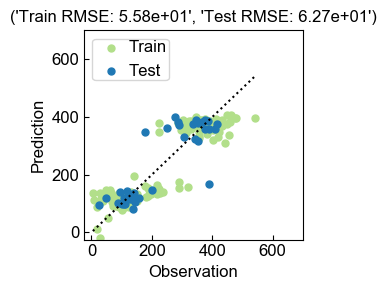

[1.91024685e+00 2.46667510e-01 2.69803707e+01 2.93040717e+01
 4.90347616e+01 6.39275244e+02 6.39275244e+02 8.04294514e+01
 2.49115704e+02 6.82970952e+01 8.80613911e-01 1.09733523e+02
 1.36189626e+01 1.05841199e+02]


In [14]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lr_regressor = LinearRegression()

# Fit to the training set
lr = lr_regressor.fit(X_train_stand, y_train)

# Perform predictions on both training and test sets
y_train_hat = lr_regressor.predict(X_train_stand)
y_test_hat = lr_regressor.predict(X_test_stand)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)
# prediction_vs_ground_truth_both_fig(y_train, y_train_hat_std, y_test, y_test_hat_std,
#                                        y_train_hat_nonstd, y_test_hat_nonstd)
print(np.abs(lr_regressor.coef_))

#### Feature importance Rank of the Linear Regression

Looking at the coefficients for the linear regression, we can try to understand which features are important for the model.

Text(0.5, 0, 'Linear regressor coefficients')

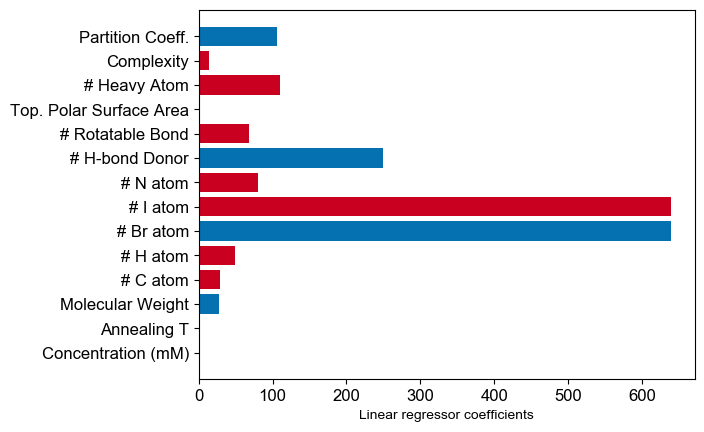

In [15]:
importances = lr.coef_
# print(abs(importances))
# plt.bar(abs(importances))
features = (list(X.columns))
color_list = np.where(importances>0,'#ca0020','#0571b0')
# print(color_list)

ax = plt.barh(features,abs(importances),color = color_list)
# ax.set_xlabel("SHAP Value (Red = Positive Impact)")
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'font.size': 12})
plt.xlabel('Linear regressor coefficients')

### K-Nearest Neighbors

Using `sklearn`, we can import the K-nearest neighbors regression model to train the dataset. We are also using `GridSearchCV` to find the optimum parameters. We also use 5-fold cross-validation within the grid search, to prevent overfitting.

In [16]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Choosing parameters for KNN
def parameterChoosing(self):
    # Set the parameters by cross-validation
    tuned_parameters = [{'weights': ['uniform', 'distance'],
                         'n_neighbors': range(2,20),
                         'algorithm': ['ball_tree,kd_tree,brute']
                        }]
    
def rfr_model(X, y):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=KNeighborsRegressor(),
        param_grid={'weights': ['uniform', 'distance'],
                    'n_neighbors': range(2,20),
                    'algorithm': ['ball_tree','kd_tree','brute']
                   },
        cv=5, 
        scoring= 'neg_mean_squared_error',
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    return best_params

print('The best parameters: ',rfr_model(X_train_stand,y_train))

The best parameters:  {'algorithm': 'brute', 'n_neighbors': 2, 'weights': 'uniform'}


C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


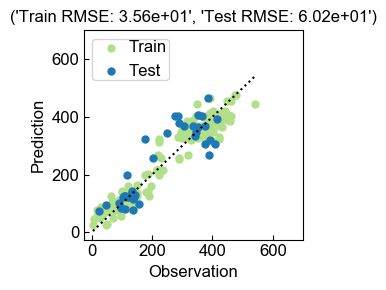

In [17]:
knn_regressor = KNeighborsRegressor(algorithm='brute',
                                   n_neighbors=2,
                                   weights='uniform')

# Fit to the training set
knn_regressor.fit(X_train_stand, y_train)
# Perform predictions on both training and test sets
y_train_hat = knn_regressor.predict(X_train_stand)
y_test_hat = knn_regressor.predict(X_test_stand)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

### Random Forest

Using `sklearn`, we can import the random forest regression model to train the dataset. We are also using `GridSearchCV` to find the optimum parameters. We also use 5-fold cross-validation within the grid search, to prevent overfitting.

In [18]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(1,5),
            'n_estimators': (5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
                                random_state=False, verbose=False)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')#'neg_mean_absolute_error')

    return best_params

print('The best parameters: ',rfr_model(X_train_stand,y_train))

C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters:  {'max_depth': 3, 'n_estimators': 80}


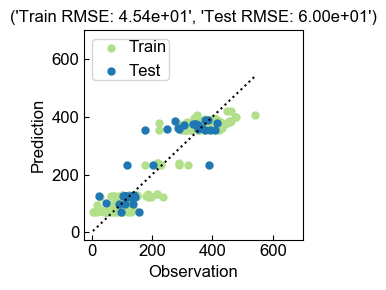

array([8.11665916e-03, 8.50355908e-03, 4.08476342e-02, 3.17648992e-03,
       5.88867320e-03, 2.70542207e-04, 1.99590810e-04, 0.00000000e+00,
       5.20817284e-01, 1.05908251e-02, 3.81622382e-01, 2.65871864e-04,
       5.00053329e-03, 1.46999548e-02])

In [19]:
rf_regressor = RandomForestRegressor(n_estimators=50,
                                     max_depth =3,
                                     random_state=1)

# Fit to the training set
rf_regressor.fit(X_train_stand, y_train)
# Perform predictions on both training and test sets
y_train_hat = rf_regressor.predict(X_train_stand)
y_test_hat = rf_regressor.predict(X_test_stand)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)
rf_regressor.feature_importances_

### Gradient Boosting Decision Tree

Using `sklearn`, we can import the gradient boosting decision tree regression model to train the dataset. We are also using `GridSearchCV` to find the optimum parameters. We also use 5-fold cross-validation within the grid search, to prevent overfitting.

In [20]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid={
            'max_depth': range(1,5),
            'n_estimators': (5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    return best_params

print('The best parameters: ',rfr_model(X_train_stand,y_train))

The best parameters:  {'max_depth': 3, 'n_estimators': 30}


C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


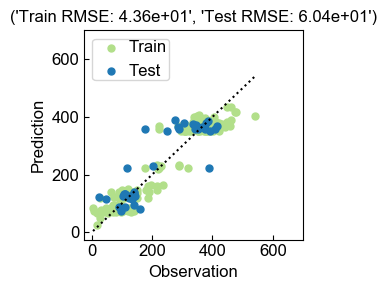

In [21]:
gb_regressor = GradientBoostingRegressor(max_depth = 2,
                                         n_estimators=80, random_state=1)

# Fit to the training set
gb_regressor.fit(X_train_stand, y_train)
# Perform predictions on both training and test sets
y_train_hat = gb_regressor.predict(X_train_stand)
y_test_hat = gb_regressor.predict(X_test_stand)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

### Neural Network (MLP Regressor)

Using `sklearn`, we can import the MLP (multi-layer perceptron) regression model to train the dataset. This algorithm uses stochastic gradient descent. We are also using `GridSearchCV` to find the optimum parameters. We also use 5-fold cross-validation within the grid search, to prevent overfitting.

We also look at different activation functions: tanh, relu, and identity.

In [22]:
# Neural Network
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

nn_regressor = MLPRegressor(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(128, 256, 64,)],
    'activation': ['tanh', 'logistic'],#,'identity'],
    'solver': ['sgd','adam','lbfgs'],#, 'adam'],
    'alpha': [0.0001,0.001,0.01],#, 0.05],
    'learning_rate': ['constant','adaptive']#,'adaptive'],
}

# y_train.fillna(y_train.mean())
clf = GridSearchCV(nn_regressor, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_stand, y_train)

print('The best parameters: \n', clf.best_params_)

C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters: 
 {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 256, 64), 'learning_rate': 'constant', 'solver': 'lbfgs'}


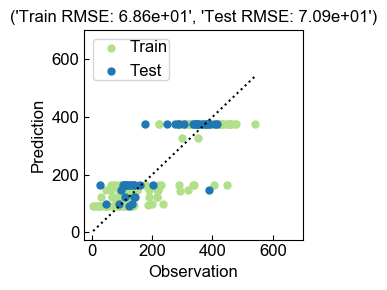

In [23]:
# nn_regressor = MLPRegressor(hidden_layer_sizes=(128, 256, 64,), max_iter=1000, solver='adam', random_state=1)
nn_regressor = MLPRegressor(hidden_layer_sizes =(128,256,64),max_iter=1000,
                           learning_rate='adaptive',solver='lbfgs',alpha=0.01,
                           activation='logistic',random_state=1)

# Fit to the training set
nn_regressor.fit(X_train, y_train)
# Perform predictions on both training and test sets
y_train_hat = nn_regressor.predict(X_train)
y_test_hat = nn_regressor.predict(X_test)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

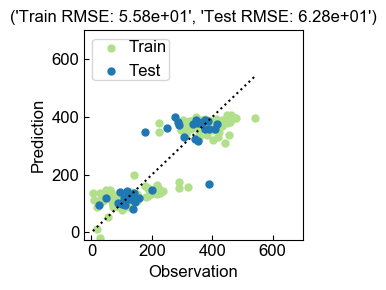

In [24]:
# nn_regressor = MLPRegressor(hidden_layer_sizes=(128, 256, 64,), max_iter=1000, solver='adam', random_state=1)
nn_regressor = MLPRegressor(hidden_layer_sizes =(128,256,64),max_iter=10000,
                           learning_rate='constant',solver='lbfgs',alpha=0.01,
                           activation='identity',random_state=1)

# Fit to the training set
nn_regressor.fit(X_train, y_train)
# Perform predictions on both training and test sets
y_train_hat = nn_regressor.predict(X_train)
y_test_hat = nn_regressor.predict(X_test)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

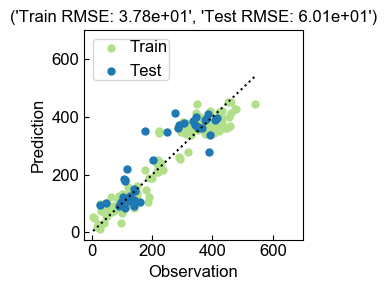

In [25]:
# nn_regressor = MLPRegressor(hidden_layer_sizes=(128, 256, 64,), max_iter=1000, solver='adam', random_state=1)
nn_regressor = MLPRegressor(hidden_layer_sizes =(128,256,64),max_iter=10000,
                           learning_rate='adaptive',solver='adam',alpha=10,
                           activation='relu',random_state=1)

# Fit to the training set
nn_regressor.fit(X_train, y_train)
# Perform predictions on both training and test sets
y_train_hat = nn_regressor.predict(X_train)
y_test_hat = nn_regressor.predict(X_test)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

### Support Vector Machine-Regression (SVR)

Using `sklearn`, we can import the support vector machine regression model to train the dataset. This algorithm uses stochastic gradient descent. We are also using `GridSearchCV` to find the optimum parameters. We also use 5-fold cross-validation within the grid search, to prevent overfitting.

In [26]:
# SVR
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=SVR(),
        param_grid={
            "C": [1e0,5, 1e1,50, 1e2,5e2,1e3],
#             "gamma": 'auto'
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    return best_params

print('The best parameters: \n',rfr_model(X_train_stand,y_train))

The best parameters: 
 {'C': 100.0}


C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


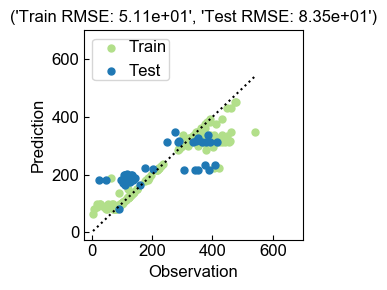

In [27]:
sv_regressor = SVR(C=100,kernel='rbf')

# Fit to the training set
sv_regressor.fit(X_train, y_train)
# Perform predictions on both training and test sets
y_train_hat = sv_regressor.predict(X_train)
y_test_hat = sv_regressor.predict(X_test)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

## Model Selection: Cross Validation

Cross validation is a model selection technique that tests **how well a model generalizes** to an independent data set. The image below shows a k-fold cross validation where packets comprising of 1/k of data alternate to be the test data in every iteration. A score averaging all the test performance can be used to compare various models' performances.

RMSE scores for LR, KNN, RF, GB, NN, SVR:  [277.0229973985971, 136.8931735864947, 90.1404011460161, 96.92537076218456, 107.52295487563677, 151.51741789476787]
Std. dev:  [216.77195078478366, 72.18994264533079, 40.7983884381736, 40.631375960478636, 44.95413432150093, 39.21083969655852]


C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Titan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

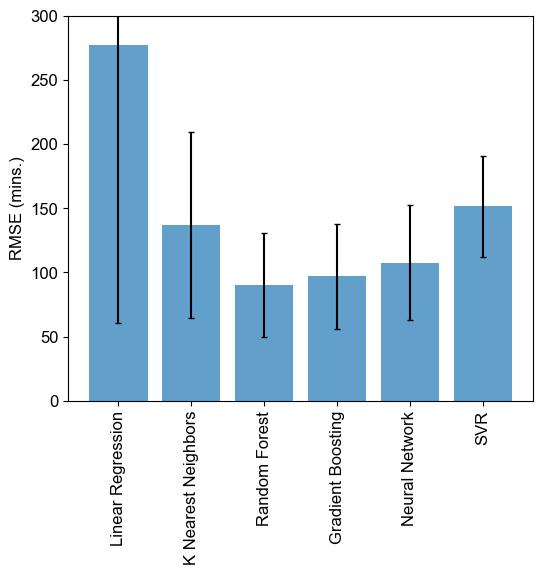

In [28]:
from sklearn.model_selection import cross_val_score

# Standardize all X
# X_stand = scaler.transform(X)
X_stand = X

# Obtain cross-validation scores of various regressors
lr_score = cross_val_score(lr_regressor, X_stand, y, cv=5, scoring='neg_mean_squared_error')
knn_score = cross_val_score(knn_regressor, X_stand, y, cv=5, scoring='neg_mean_squared_error')
rf_score = cross_val_score(rf_regressor, X_stand, y, cv=5, scoring='neg_mean_squared_error')
gb_score = cross_val_score(gb_regressor, X_stand, y, cv=5, scoring='neg_mean_squared_error')
nn_score = cross_val_score(nn_regressor, X_stand, y, cv=5, scoring='neg_mean_squared_error')
svr_score = cross_val_score(sv_regressor,X_stand, y, cv=5, scoring='neg_mean_squared_error')

# Plot the cross-validation scores of the various regressors
fig,ax = plt.subplots(figsize=(6,5))
model = ['Linear Regression', 'K Nearest Neighbors', 'Random Forest', 'Gradient Boosting', 'Neural Network','SVR']
scores = [np.mean(np.sqrt(-lr_score)), np.mean(np.sqrt(-knn_score)), np.mean(np.sqrt(-rf_score)), np.mean(np.sqrt(-gb_score)), np.mean(np.sqrt(-nn_score)),np.mean(np.sqrt(-svr_score))]
std  = [np.std(np.sqrt(-lr_score)), np.std(np.sqrt(-knn_score)), np.std(np.sqrt(-rf_score)), np.std(np.sqrt(-gb_score)), np.std(np.sqrt(-nn_score)),np.std(np.sqrt(-svr_score))]
print('RMSE scores for LR, KNN, RF, GB, NN, SVR: ' ,scores)
print('Std. dev: ',std)
fontsize = 12
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
ax.bar(model,scores,yerr=std,alpha=0.7, capsize=2)
ax.set_ylabel('RMSE (mins.)',fontsize=fontsize)
# ax.set_title('Cross Validation Score',fontsize=fontsize)
plt.xticks(rotation=90)
plt.ylim(0,300)
plt.show()
plt.rcParams['font.family']="Arial"

# Uncomment to save fig
# plt.tight_layout()
fig.savefig('20200505_nonstandardized_CV_excPTEAI_1.png', dpi = 1200,bbox_inches='tight') 

## Using SHAP for Interpretability

To interpret the trained models, we are using `SHAP` (https://github.com/slundberg/shap). Shapley values come from game theory, and explain the allocation of each features to the output (this can be read further here: https://www.nature.com/articles/s42256-019-0138-9.epdf). We can use it on the tree-based algorithms, such as random forest regression and gradient boosting tree regression. 

From the previous result, we see that the best models with lowest RMSE on standardized $X$ comes from tree-based models. We will look at their feature importance ranks, to see which feature contributes the most to the output ($y$) and is responsible for the degradation to happen.

Also, **note that you don't need to standardized/ normalized $X$ for partitioning algorithms, including all the tree-based algorithms**, such as random forest (RF), or gradient boosting decision tree (GB) regressions. Tree-based algorithms are more robust to numerical instabilities. Since that's the case, we are going to retrain the RF and GB on non-standardized/ non-normalized values.

In [29]:
# First, install and import shap
# !pip install shap

import shap

### Random Forest SHAP

This is the SHAP result for random forest regression. 

In [30]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(1,5),
            'n_estimators': (5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],\
                                random_state=False, verbose=False)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')#'neg_mean_absolute_error')

    return best_params

print('The best parameters: ',rfr_model(X_train,y_train))

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


The best parameters:  {'max_depth': 3, 'n_estimators': 40}


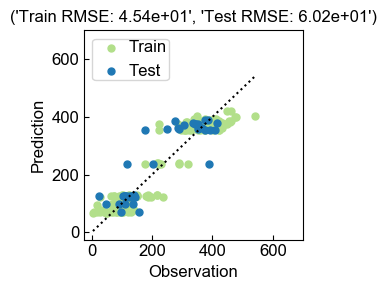

In [31]:
rf_regressor = RandomForestRegressor(n_estimators=40,
                                     max_depth =3,
                                     random_state=1)

# Fit to the training set
rf_regressor.fit(X_train, y_train)

# Perform predictions on both training and test sets
y_train_hat = rf_regressor.predict(X_train)
y_test_hat = rf_regressor.predict(X_test)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

In [32]:
# Use shap to explain our rf_regressor
explainerRF = shap.TreeExplainer(rf_regressor,check_additivity=False)

# Get standardized X Dataframe
X_stand_df = dataValues_X
shap_values_RF_test = explainerRF.shap_values(X_stand_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


What if we want to check entry 33 (dodecylammonium iodide), and see how their parameters contribute to the degradation onset:

In [33]:
shap.initjs() # Load JS visualization

# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
k = 33

shap.force_plot(explainerRF.expected_value, shap_values_RF_test[k,:], X_stand_df.iloc[k,:], plot_cmap='plasma', show = True) 

# Uncomment the following to save the figure: , show = False, matplotlib = True)
# Uncomment below to save the figure
# plt.tight_layout()
# plt.savefig('forceplot_test.png', dpi = 400, figsize=(20,20))

What if we want to check entry 123 (phenyltriethylammonium iodide), and see how their parameters contribute to the degradation onset:

In [34]:
shap.initjs() # Load JS visualization

# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
k = 123

shap.force_plot(explainerRF.expected_value, shap_values_RF_test[k,:], X_stand_df.iloc[k,:], show = True) 

# Uncomment the following to save the figure: , show = False, matplotlib = True)
# Uncomment below to save the figure
# plt.tight_layout()
# plt.savefig('forceplot_test.png', dpi = 400, figsize=(20,20))

What if we want to check how the trend is for the whole dataset?

In [35]:
shap.initjs() # Load JS visualization

# Visualize the whole dataset predictions
shap.force_plot(explainerRF.expected_value, shap_values_RF_test, X_stand_df)

# Again, uncomment this if you want to save it as a fig.
# plt.savefig('forceplot_all.png', dpi = 400, figsize=(20,20))

What about the feature importance ranks?

The yellow indicates high feature value, and the purple indicates low feature value. The SHAP value represents our degradation parameters, which is $y$ in our models.

The result shows that when we have high value of top. polar surface area and # H-bond donor, the SHAP value decreases. Since we have chosen $y$ to be the degradation onset time for R, when we have low value of this parameter, the film degrades faster.

| TPSA | # H-bond donor | SHAP | $y$ | Degradation |
|-|-|-|-|-|
| High TPSA/ larger polar area | High # H-bond donor | Low SHAP value | Low $y$ value | Degrades faster |
| Low TPSA/ smaller polar area | Low # H-bond donor | High SHAP value | High $y$ value | Degrades slower |

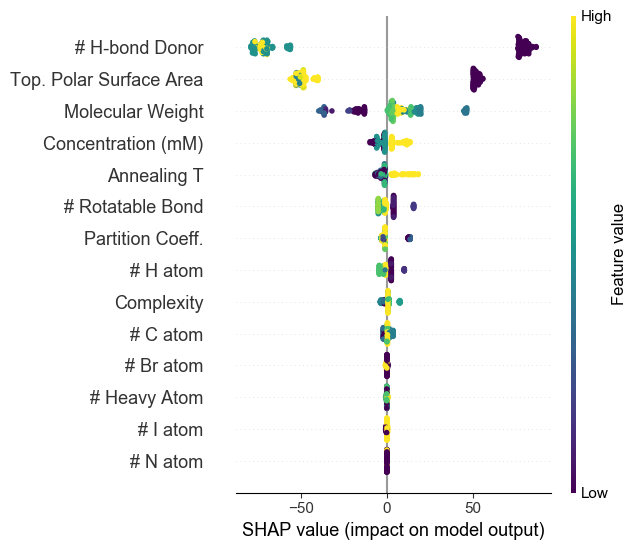

In [36]:
plt.figure()
shap.summary_plot(shap_values_RF_test, X_stand_df,plot_type = "dot",
                            #color=plt.get_cmap("plasma"),
                           show = False)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'font.size': 60})

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
my_cmap = plt.get_cmap('viridis')
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
plt.savefig('20200505_rf_nonstd_shap_excPTEAI.png', dpi = 1200) 

#### Testing New Compounds/ Molecules with Random Forest

What if we would like to see how the other compounds/ molecules perform based on trained random forest regression? We can load the dataset of the molecular properties, and get the prediction.

For example, we would like to check the following:
1. Benzylphosphonic acid
2. 4-cyanobenzyl phosphonic acid
3. Theophylline (https://doi.org/10.1126/science.aay9698)
4. Caffeine (https://doi.org/10.1126/science.aay9698)
5. Theobromine (https://doi.org/10.1126/science.aay9698)
6. PTEAI (the most stable one from the experiment)

In [37]:
# Load the molecular properties dataset we would like to predict
degData_X_lit = pd.read_csv('dataset/predict_withPTEAI.csv')

# Check if the data is loaded and separated correctly
pd.set_option('max_rows', 10)
degData_X_lit

,compound,Concentration (mM),Annealing T,Molecular Weight,# C atom,# H atom,# Br atom,# I atom,# N atom,# H-bond Donor,# Rotatable Bond,Top. Polar Surface Area,# Heavy Atom,Complexity,Partition Coeff.
0,benzylphosphonic acid,0.05,100,172.120,7,9,0,0,0,2,2,57.5,11,157,-0.1
1,4-Cyanobenzyl phosphonic acid,0.05,100,197.130,8,8,0,0,1,2,2,81.3,13,256,-0.4
2,Theophylline,10.00,100,180.160,7,8,0,0,4,1,0,69.3,13,267,0.0
3,Caffeine,10.00,100,194.190,8,10,0,0,4,0,0,58.4,14,293,-0.1
4,Theobromine,10.00,100,180.160,7,8,0,0,4,1,0,67.2,13,267,-0.8
5,PTEAI,10.00,100,305.203,12,20,0,1,1,0,4,0.0,14,124,2.9


In [38]:
# Read the dataframe
dataValues_X_lit = pd.DataFrame(degData_X_lit)
X_lit = dataValues_X_lit.drop(['compound'],axis=1) # Only consists of X
name_lit = dataValues_X_lit[['compound']] # Only consists of the name

# Predict the output
prediction_rf = rf_regressor.predict(X_lit)
# print(prediction_rf.size)
# print(name_lit.to_numpy())

The prediction values : [109.3341655  113.07791534 107.82219112 274.43870953 128.30393795
 355.77746607]


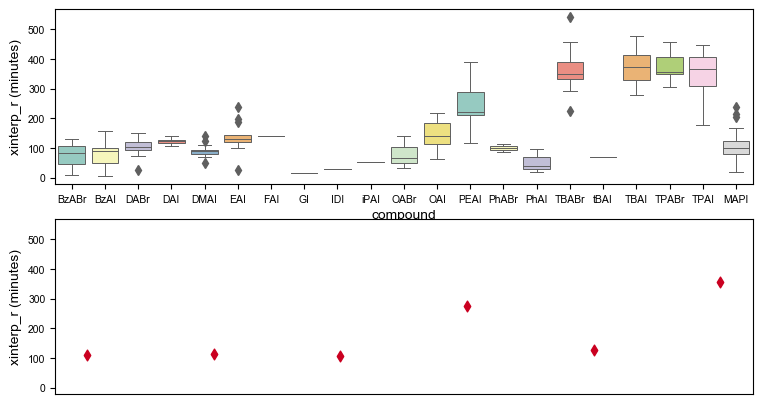

In [52]:
# Plot the prediction values in comparison to observed/ experimental data points

# Top plot
fig, axes = plt.subplots(2,1, figsize=(9,5), sharey=True)
plt.style.use('default')
fontsize = 7.5

sns.boxplot(x='compound', y='xinterp_r', data=degData_y, 
            palette = 'Set3',ax=axes[0],linewidth=0.7)
axes[0].set_ylabel('xinterp_r (minutes)')

# Bottom plot
number = np.arange(prediction_rf.size)
axes[1].scatter(number,prediction_rf,s=30,c='#ca0020',marker='d')
axes[1].set_ylabel('xinterp_r (minutes)')
axes[1].set_xticks([])

# for i, txt in enumerate(name_lit.to_numpy()):
#     axes[1].annotate(txt, (number[i], prediction_rf[i]),size=fontsize)
    
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams['font.family']="Arial"

print('The prediction values :',prediction_rf)

### Gradient Boosting Decision Tree SHAP

This is the SHAP result for gradient boosting decision tree regression.

In [40]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid={
            'max_depth': range(1,5),
            'n_estimators': (5,10,20,30,40,50,60,70,80,90,100,500,1000),
        },
        cv=5, 
        scoring= 'neg_mean_squared_error', 
        #'neg_mean_squared_error',
        verbose=0,
        n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    return best_params

print('The best parameters: ',rfr_model(X_train,y_train))

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


The best parameters:  {'max_depth': 2, 'n_estimators': 80}


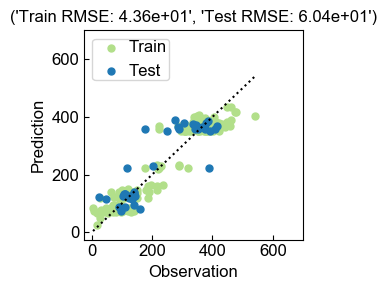

In [41]:
gb_regressor = GradientBoostingRegressor(max_depth = 2,
                                         n_estimators=80, random_state=1)

# Fit to the training set
gb_regressor.fit(X_train, y_train)

# Perform predictions on both training and test sets
y_train_hat = gb_regressor.predict(X_train)
y_test_hat = gb_regressor.predict(X_test)

# Visualize the results
prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)

In [42]:
# Use shap to explain our gb_regressor
explainerGB = shap.TreeExplainer(gb_regressor,check_additivity=False)

# Get standardized X Dataframe
X_stand_df = dataValues_X
shap_values_RF_test = explainerGB.shap_values(X_stand_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


What if we want to check entry 33 (dodecylammonium iodide), and see how their parameters contribute to the degradation onset:

In [43]:
shap.initjs() # Load JS visualization

# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
k = 33

shap.force_plot(explainerGB.expected_value, shap_values_RF_test[k,:], X_stand_df.iloc[k,:], plot_cmap='plasma', show = True) 
# Uncomment the following to save the figure: , show = False, matplotlib = True)

# Uncomment below to save the figure
# plt.tight_layout()
# plt.savefig('forceplot_test.png', dpi = 400, figsize=(20,20))

What if we want to check entry 123 (phenyltriethylammonium iodide), and see how their parameters contribute to the degradation onset:

In [44]:
shap.initjs() # Load JS visualization

# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
k = 123

shap.force_plot(explainerGB.expected_value, shap_values_RF_test[k,:], X_stand_df.iloc[k,:], show = True) 
# Uncomment the following to save the figure: , show = False, matplotlib = True)

# Uncomment below to save the figure
# plt.tight_layout()
# plt.savefig('forceplot_test.png', dpi = 400, figsize=(20,20))

What if we want to check how the trend is for the whole dataset?

In [45]:
shap.initjs() # Load JS visualization

# Visualize the whole dataset predictions
shap.force_plot(explainerGB.expected_value, shap_values_RF_test, X_stand_df)

# Again, uncomment this if you want to save it as a fig.
# plt.savefig('forceplot_all.png', dpi = 400, figsize=(20,20))

What about the feature importance ranks for the GB? In comparison to the RF, the top 4 features: # H-bond donor, top.polar surface area, molecular weight, and concentration consistently stay as the most important features. 

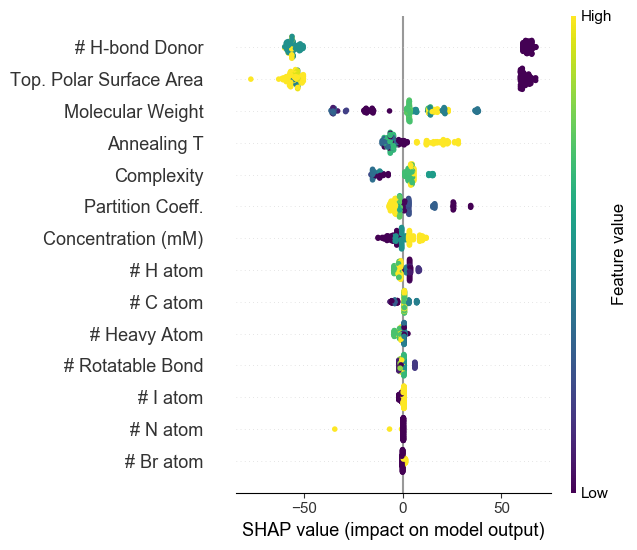

In [46]:
plt.figure()
summary = shap.summary_plot(shap_values_RF_test, X_stand_df,plot_type = "dot",
                            color=plt.get_cmap("plasma"),
                           show = False)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'font.size': 60})
# plt.get_cmap("plasma")

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
my_cmap = plt.get_cmap('viridis')
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
plt.savefig('20200505_gb_nonstd_shap_excPTEAI.png', dpi = 1200) 

#### Testing New Compounds/ Molecules with Gradient Boosting Decisiton Tree

What if we would like to see how the other compounds/ molecules perform based on trained gradient boosting decision tree regression? We can load the dataset of the molecular properties, and get the prediction.

For example, we would like to check the following:
1. Benzylphosphonic acid
2. 4-cyanobenzyl phosphonic acid
3. Theophylline (https://doi.org/10.1126/science.aay9698)
4. Caffeine (https://doi.org/10.1126/science.aay9698)
5. Theobromine (https://doi.org/10.1126/science.aay9698)
6. PTEAI (the most stable one from the experiment)

In [47]:
# Load the molecular properties dataset we would like to predict
degData_X_lit = pd.read_csv('dataset/predict_withPTEAI.csv')

# Check if the data is loaded and separated correctly
pd.set_option('max_rows', 10)
degData_X_lit

,compound,Concentration (mM),Annealing T,Molecular Weight,# C atom,# H atom,# Br atom,# I atom,# N atom,# H-bond Donor,# Rotatable Bond,Top. Polar Surface Area,# Heavy Atom,Complexity,Partition Coeff.
0,benzylphosphonic acid,0.05,100,172.120,7,9,0,0,0,2,2,57.5,11,157,-0.1
1,4-Cyanobenzyl phosphonic acid,0.05,100,197.130,8,8,0,0,1,2,2,81.3,13,256,-0.4
2,Theophylline,10.00,100,180.160,7,8,0,0,4,1,0,69.3,13,267,0.0
3,Caffeine,10.00,100,194.190,8,10,0,0,4,0,0,58.4,14,293,-0.1
4,Theobromine,10.00,100,180.160,7,8,0,0,4,1,0,67.2,13,267,-0.8
5,PTEAI,10.00,100,305.203,12,20,0,1,1,0,4,0.0,14,124,2.9


In [48]:
# Read the dataframe
dataValues_X_lit = pd.DataFrame(degData_X_lit)
X_lit = dataValues_X_lit.drop(['compound'],axis=1) # Only consists of X
name_lit = dataValues_X_lit[['compound']] # Only consists of the name

# Predict the output
prediction_gb = gb_regressor.predict(X_lit)
# print(prediction_gb.size)
# print(name_lit.to_numpy())

The GB prediction values : [124.79659255 107.09760031  52.39490429 193.99564934  68.67616312
 363.96313769]


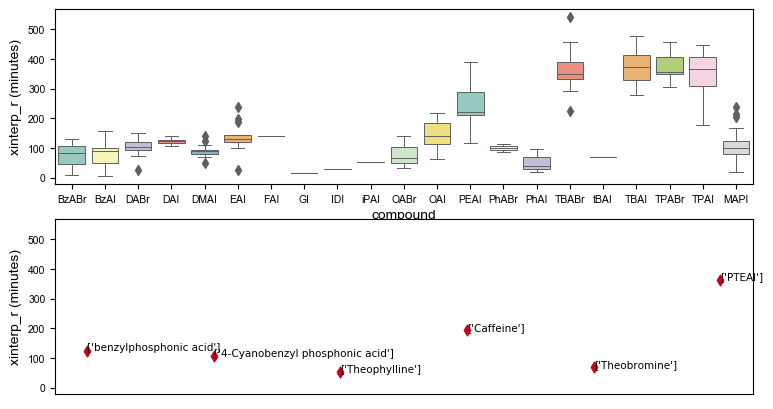

In [50]:
# Plot the prediction values in comparison to observed/ experimental data points

# Top plot
fig, axes = plt.subplots(2,1, figsize=(9,5), sharey=True)
plt.style.use('default')
fontsize = 7.5

sns.boxplot(x='compound', y='xinterp_r', data=degData_y, 
            palette = 'Set3',ax=axes[0],linewidth=0.7)
axes[0].set_ylabel('xinterp_r (minutes)')

# Bottom plot
number = np.arange(prediction_gb.size)
axes[1].scatter(number,prediction_gb,s=30,c='#ca0020',marker='d')
axes[1].set_ylabel('xinterp_r (minutes)')
axes[1].set_xticks([])

for i, txt in enumerate(name_lit.to_numpy()):
    axes[1].annotate(txt, (number[i], prediction_gb[i]),size=fontsize)
    
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams['font.family']="Arial"

print('The GB prediction values :',prediction_gb)

### Linear Regression SHAP

This is the SHAP result for linear regression.

In [53]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lr_regressor = LinearRegression()

# Fit to the training set
lr = lr_regressor.fit(X_train_stand, y_train)

# Perform predictions on both training and test sets
# y_train_hat = lr_regressor.predict(X_train_stand)
# y_test_hat = lr_regressor.predict(X_test_stand)

# # Visualize the results
# prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat)
# # prediction_vs_ground_truth_both_fig(y_train, y_train_hat_std, y_test, y_test_hat_std,
# #                                        y_train_hat_nonstd, y_test_hat_nonstd)
# print(np.abs(lr_regressor.coef_))

In [54]:
lr_explainer = shap.KernelExplainer(lr_regressor.predict,X_stand_df)
lr_shap_values = lr_explainer.shap_values(X_stand_df)

Using 198 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

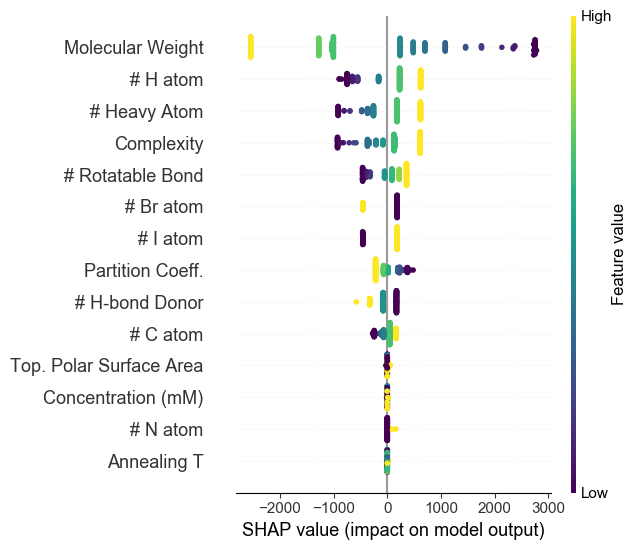

In [55]:
plt.figure()
summary = shap.summary_plot(lr_shap_values, X_stand_df,plot_type = "dot",
                            color=plt.get_cmap("plasma"),
                           show = False)

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'font.size': 60})

# Change the colormap of the artists, UNCOMMENT FOR DEFAULT COLORMAP
my_cmap = plt.get_cmap('viridis')
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

plt.tight_layout()

# UNCOMMENT TO SAVE A FIGURE
plt.savefig('20200505_lr_nonstand_shap_excPTEAI_1.png', dpi = 1200) 

## Conclusion

The clear trend is shown in the # H-bond donor and top. plar surface area, showing that for the capping layer materials, we need to have lower # H-bond donor and smaller polar surface area in the organic *A*-site cation molecules.